In [165]:
# Import required libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, Polygon, box
from shapely.ops import unary_union, transform
import warnings
from datetime import datetime, timedelta
import os
import glob
from pathlib import Path
from scipy.interpolate import griddata
from scipy.ndimage import binary_dilation
import pyproj
from functools import partial
import seaborn as sns
from sklearn.metrics import brier_score_loss
from tqdm import tqdm
import pickle

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.dpi'] = 100

print("✅ All libraries imported successfully!")
print("📊 Matplotlib settings configured for high-quality plots")


✅ All libraries imported successfully!
📊 Matplotlib settings configured for high-quality plots


In [166]:
# Configuration and Paths
BASE_PATH = Path("/Users/jimnguyen/IRMII/SCS_API")
OUTLOOK_PATH = BASE_PATH / "convective_outlooks_only1200z"
PPH_HAIL_PATH = BASE_PATH / "PPH" / "NCEI_PPH" / "hail"
PPH_SIGHAIL_PATH = BASE_PATH / "PPH" / "Sighail_PPH" / "sighail"
REPORTS_HAIL_PATH = BASE_PATH / "NCEI_storm_reports" / "hail_filtered"
REPORTS_SIGHAIL_PATH = BASE_PATH / "NCEI_storm_reports" / "sighail_filtered"
NAM212_PATH = BASE_PATH / "PPH" / "nam212.nc"

# Output directory structure
OUTPUT_PATH = BASE_PATH / "analysis_outputs"
FIGURES_PATH = OUTPUT_PATH / "figures"
MEAN_ANNUAL_PATH = FIGURES_PATH / "mean_annual_event_days"
TIME_SERIES_PATH = FIGURES_PATH / "time_series"
BRIER_SCORES_PATH = FIGURES_PATH / "brier_scores"
PERFORMANCE_PATH = FIGURES_PATH / "performance_diagrams"

START_YEAR = 2010
END_YEAR = 2024
HAIL_THRESHOLDS = [15, 30]
SIGHAIL_THRESHOLDS = [10]

# Create output directories
os.makedirs("cache", exist_ok=True)
os.makedirs(MEAN_ANNUAL_PATH, exist_ok=True)
os.makedirs(TIME_SERIES_PATH, exist_ok=True)
os.makedirs(BRIER_SCORES_PATH, exist_ok=True)
os.makedirs(PERFORMANCE_PATH, exist_ok=True)

print(f"✅ Configuration set for {START_YEAR}-{END_YEAR}")
print(f"📁 Output directories created:")
print(f"   📊 Figures: {FIGURES_PATH}")
print(f"   🗺️ Mean Annual: {MEAN_ANNUAL_PATH}")
print(f"   📈 Time Series: {TIME_SERIES_PATH}")
print(f"   🎯 Brier Scores: {BRIER_SCORES_PATH}")
print(f"   📋 Performance: {PERFORMANCE_PATH}")


✅ Configuration set for 2010-2024
📁 Output directories created:
   📊 Figures: /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures
   🗺️ Mean Annual: /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/mean_annual_event_days
   📈 Time Series: /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/time_series
   🎯 Brier Scores: /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/brier_scores
   📋 Performance: /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/performance_diagrams


In [167]:
# Load NAM212 Grid
nam212_ds = xr.open_dataset(NAM212_PATH)
grid_lats = nam212_ds['gridlat_212'].values
grid_lons = nam212_ds['gridlon_212'].values
grid_shape = grid_lats.shape
CELL_AREA_KM2 = 40.6 * 40.6

print(f"🗺️ NAM212 Grid: {grid_shape[0]} x {grid_shape[1]} = {grid_shape[0] * grid_shape[1]:,} cells")
print(f"📏 Cell area: {CELL_AREA_KM2:,.1f} km² per cell")


🗺️ NAM212 Grid: 129 x 185 = 23,865 cells
📏 Cell area: 1,648.4 km² per cell


In [168]:
#Shapefile to NAM212 Grid Conversion
def shapefile_to_nam212_grid(shapefile_path, threshold_value, grid_shape, grid_lons, grid_lats):
    """Convert shapefile polygons to NAM212 grid format with projection handling."""
    try:
        gdf = gpd.read_file(shapefile_path)
        grid = np.zeros(grid_shape)
        
        if len(gdf) == 0:
            return grid
        
        # Filter by threshold using DN column
        if 'DN' in gdf.columns:
            threshold_gdf = gdf[gdf['DN'] == threshold_value].copy()
        else:
            threshold_rows = []
            for idx, row in gdf.iterrows():
                if str(threshold_value) in str(row.to_dict()):
                    threshold_rows.append(row)
            if threshold_rows:
                threshold_gdf = gpd.GeoDataFrame(threshold_rows, crs=gdf.crs)
            else:
                return grid
        
        if len(threshold_gdf) == 0:
            return grid
        
        # CRITICAL FIX: Check projection and reproject if needed
        sample_geom = threshold_gdf.iloc[0].geometry
        if sample_geom is not None:
            if hasattr(sample_geom, 'exterior'):
                x, y = list(sample_geom.exterior.coords)[0]
            else:
                x, y = list(sample_geom.geoms[0].exterior.coords)[0]
            
            # If coordinates > 180, it's projected (Lambert Conformal Conic)
            if abs(x) > 180 or abs(y) > 90:
                print(f"   Reprojecting from {threshold_gdf.crs} to WGS84")
                threshold_gdf = threshold_gdf.to_crs('EPSG:4326')
        
        # Merge polygons and check grid points
        all_geoms = [row.geometry for idx, row in threshold_gdf.iterrows() 
                    if row.geometry is not None and row.geometry.is_valid]
        
        if not all_geoms:
            return grid
            
        merged_geom = unary_union(all_geoms)
        if merged_geom.is_empty:
            return grid
            
        minx, miny, maxx, maxy = merged_geom.bounds
        
        for i in range(grid_shape[0]):
            for j in range(grid_shape[1]):
                lon, lat = grid_lons[i, j], grid_lats[i, j]
                if minx <= lon <= maxx and miny <= lat <= maxy:
                    if merged_geom.contains(Point(lon, lat)):
                        grid[i, j] = 1.0
        
        return grid
        
    except Exception as e:
        print(f"   ⚠️ Error processing {shapefile_path}: {e}")
        return np.zeros(grid_shape)

print("✅ Projection handling function defined with critical fix")


✅ Projection handling function defined with critical fix


In [169]:
# Utility Functions
def get_outlook_path(date, hazard_type='hail'):
    """Get outlook shapefile path."""
    year, month, day = date.year, date.month, date.day
    base_path = OUTLOOK_PATH / str(year) / str(month) / "forecast_day1"
    outlook_dir = base_path / f"day1otlk_{date.strftime('%Y%m%d')}_1200"
    
    if hazard_type == 'hail':
        shapefile = outlook_dir / f"day1otlk_{date.strftime('%Y%m%d')}_1200_hail.shp"
    else:
        shapefile = outlook_dir / f"day1otlk_{date.strftime('%Y%m%d')}_1200_sighail.shp"
    
    return shapefile if shapefile.exists() else None

def load_pph_data(date, hazard_type='hail'):
    """Load PPH data for a specific date."""
    if hazard_type == 'hail':
        pph_file = PPH_HAIL_PATH / f"pph_{date.strftime('%Y_%m_%d')}.csv"
    else:
        pph_file = PPH_SIGHAIL_PATH / f"pph_{date.strftime('%Y_%m_%d')}.csv"
    
    if pph_file.exists():
        return pd.read_csv(pph_file, header=0).values
    else:
        return None

def process_outlooks_for_year(hazard_type, threshold, year):
    """Process outlook data for a year with caching."""
    cache_file = f"cache/outlook_{hazard_type}_{threshold}_{year}.pkl"
    
    if os.path.exists(cache_file):
        print(f"   📦 Loading cached outlook data for {year}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    print(f"   🔄 Processing {hazard_type} {threshold}% outlooks for {year}")
    yearly_grid = np.zeros(grid_shape)
    
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    current_date = start_date
    
    days_processed = 0
    while current_date <= end_date:
        # CORRECTED: Use outlook issued on previous day (valid during current_date)
        outlook_date = current_date - timedelta(days=1)
        outlook_path = get_outlook_path(outlook_date, hazard_type)
        if outlook_path and outlook_path.exists():
            try:
                grid = shapefile_to_nam212_grid(outlook_path, threshold, grid_shape, grid_lons, grid_lats)
                if np.any(grid > 0):
                    yearly_grid += grid
                    days_processed += 1
            except:
                pass
        current_date += timedelta(days=1)
    
    print(f"      ✓ Processed {days_processed} days with {threshold}% outlook")
    
    with open(cache_file, 'wb') as f:
        pickle.dump(yearly_grid, f)
    
    return yearly_grid

def process_pph_for_year(hazard_type, threshold, year):
    """Process PPH data for a year with caching."""
    cache_file = f"cache/pph_{hazard_type}_{threshold}_{year}.pkl"
    
    if os.path.exists(cache_file):
        print(f"   📦 Loading cached PPH data for {year}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    print(f"   🔄 Processing {hazard_type} {threshold}% PPH for {year}")
    yearly_grid = np.zeros(grid_shape)
    
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    current_date = start_date
    
    days_processed = 0
    while current_date <= end_date:
        pph_data = load_pph_data(current_date, hazard_type)
        if pph_data is not None:
            yearly_grid += (pph_data >= threshold/100.0).astype(float)
            days_processed += 1
        current_date += timedelta(days=1)
    
    print(f"      ✓ Processed {days_processed} days with PPH data")
    
    with open(cache_file, 'wb') as f:
        pickle.dump(yearly_grid, f)
    
    return yearly_grid

print("✅ Utility functions defined")


✅ Utility functions defined


In [170]:
# Plotting Functions
def get_color_scheme(hazard_type, threshold):
    """Get standardized color scheme for plots."""
    if hazard_type == 'hail':
        if threshold == 15:
            colors = ['white', '#e6ffe6', '#b3ffb3', '#66ff66', '#33cc33', '#009900', '#006600', '#003300']
            levels = [0.025, 1, 4, 8, 12, 16, 20, 24]
        elif threshold == 30:
            colors = ['white', '#ffe6cc', '#ffcc99', '#ff9966', '#ff6633', '#ff3300', '#cc0000', '#660000']
            levels = [0.025, 1, 3, 6, 10, 15, 20, 30]
    else:  # sighail
        colors = ['white', '#e6f3ff', '#b3d9ff', '#66b3ff', '#3399ff', '#0066cc', '#003d7a', '#001a4d']
        levels = [0.025, 1, 2, 4, 6, 8, 10, 12]
    
    cmap = LinearSegmentedColormap.from_list(f'{hazard_type}_{threshold}', colors, N=256)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    return cmap, norm, levels

def plot_mean_annual_event_days(pph_data, outlook_data, hazard_type, threshold, custom_save_path=None):
    """Create side-by-side comparison plots with organized output structure."""
    cmap, norm, levels = get_color_scheme(hazard_type, threshold)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), 
                                   subplot_kw={'projection': ccrs.PlateCarree()})
    
    # PPH plot
    im1 = ax1.contourf(grid_lons, grid_lats, pph_data, levels=levels, cmap=cmap, norm=norm, 
                       transform=ccrs.PlateCarree(), extend='max')
    ax1.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax1.add_feature(cfeature.BORDERS, linewidth=0.8)
    ax1.set_extent([-130, -65, 20, 50], crs=ccrs.PlateCarree())
    
    max_idx = np.unravel_index(np.argmax(pph_data), pph_data.shape)
    max_val = pph_data[max_idx]
    max_lon, max_lat = grid_lons[max_idx], grid_lats[max_idx]
    ax1.plot(max_lon, max_lat, 'k+', markersize=15, markeredgewidth=3, transform=ccrs.PlateCarree())
    ax1.set_title(f'PPH {threshold}% {hazard_type.capitalize()} ({START_YEAR}-{END_YEAR})\nMax: {max_val:.1f} days', 
                  fontsize=16, weight='bold')
    
    # Outlook plot
    im2 = ax2.contourf(grid_lons, grid_lats, outlook_data, levels=levels, cmap=cmap, norm=norm, 
                       transform=ccrs.PlateCarree(), extend='max')
    ax2.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
    ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax2.add_feature(cfeature.BORDERS, linewidth=0.8)
    ax2.set_extent([-130, -65, 20, 50], crs=ccrs.PlateCarree())
    
    max_idx = np.unravel_index(np.argmax(outlook_data), outlook_data.shape)
    max_val = outlook_data[max_idx]
    max_lon, max_lat = grid_lons[max_idx], grid_lats[max_idx]
    ax2.plot(max_lon, max_lat, 'k+', markersize=15, markeredgewidth=3, transform=ccrs.PlateCarree())
    ax2.set_title(f'Convective Outlook {threshold}% {hazard_type.capitalize()} ({START_YEAR}-{END_YEAR})\nMax: {max_val:.1f} days', 
                  fontsize=16, weight='bold')
    
    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im1, cax=cbar_ax, orientation='vertical')
    cbar.set_label('Mean Annual Event Days', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    
    # Organized save path
    if custom_save_path:
        save_path = custom_save_path
    else:
        # Create organized filename and path
        filename = f"mean_annual_{hazard_type}_{threshold}pct_{START_YEAR}-{END_YEAR}.png"
        save_path = MEAN_ANNUAL_PATH / filename
    
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"💾 Saved plot to {save_path}")
    
    plt.show()
    return fig

print("✅ Plotting functions defined")


✅ Plotting functions defined


In [171]:
# Task 1A: Process HAIL 15% Data
print("🔄 PROCESSING HAIL 15%")
print("="*50)

# Process outlooks
hail_15_outlook_annual = []
for year in range(START_YEAR, END_YEAR + 1):
    grid = process_outlooks_for_year('hail', 15, year)
    hail_15_outlook_annual.append(grid)
hail_15_outlook_mean = np.mean(hail_15_outlook_annual, axis=0)

# Process PPH
hail_15_pph_annual = []
for year in range(START_YEAR, END_YEAR + 1):
    grid = process_pph_for_year('hail', 15, year)
    hail_15_pph_annual.append(grid)
hail_15_pph_mean = np.mean(hail_15_pph_annual, axis=0)

print(f"✅ HAIL 15% Complete")
print(f"   📊 PPH Max: {np.max(hail_15_pph_mean):.1f} days")
print(f"   📊 Outlook Max: {np.max(hail_15_outlook_mean):.1f} days")


🔄 PROCESSING HAIL 15%
   📦 Loading cached outlook data for 2010
   📦 Loading cached outlook data for 2011
   📦 Loading cached outlook data for 2012
   📦 Loading cached outlook data for 2013
   📦 Loading cached outlook data for 2014
   📦 Loading cached outlook data for 2015
   📦 Loading cached outlook data for 2016
   📦 Loading cached outlook data for 2017
   📦 Loading cached outlook data for 2018
   📦 Loading cached outlook data for 2019
   📦 Loading cached outlook data for 2020
   📦 Loading cached outlook data for 2021
   📦 Loading cached outlook data for 2022
   📦 Loading cached outlook data for 2023
   📦 Loading cached outlook data for 2024
   📦 Loading cached PPH data for 2010
   📦 Loading cached PPH data for 2011
   📦 Loading cached PPH data for 2012
   📦 Loading cached PPH data for 2013
   📦 Loading cached PPH data for 2014
   📦 Loading cached PPH data for 2015
   📦 Loading cached PPH data for 2016
   📦 Loading cached PPH data for 2017
   📦 Loading cached PPH data for 2018
   📦 L

📊 PLOTTING HAIL 15% COMPARISON
💾 Saved plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/mean_annual_event_days/mean_annual_hail_15pct_2010-2024.png


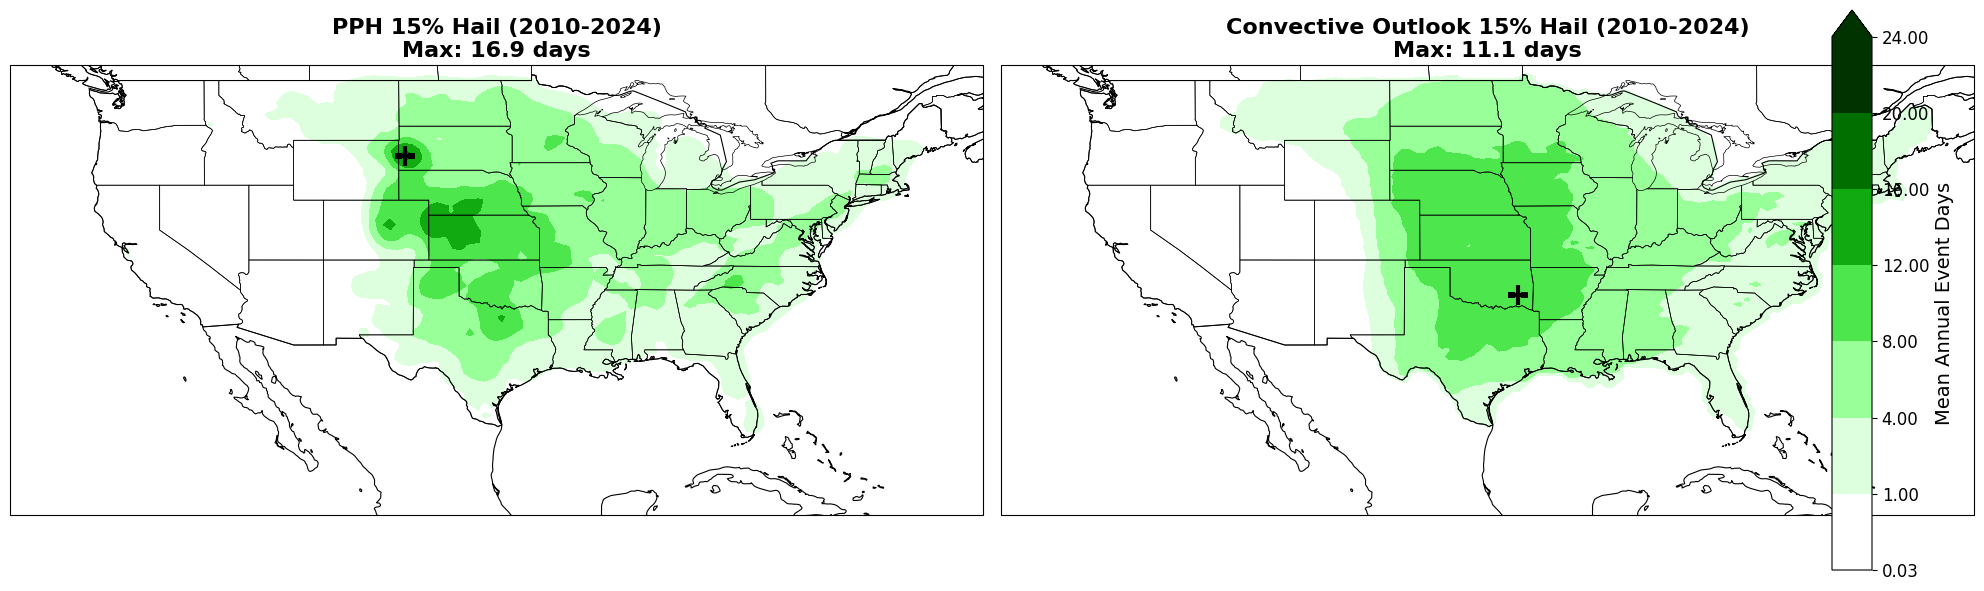

✅ HAIL 15% plot completed and saved to organized directory


In [172]:
# Task 1A: Plot HAIL 15% Results
print("📊 PLOTTING HAIL 15% COMPARISON")
print("="*50)

plot_mean_annual_event_days(hail_15_pph_mean, hail_15_outlook_mean, 'hail', 15)

print(f"✅ HAIL 15% plot completed and saved to organized directory")


In [173]:
# Task 1B: Process HAIL 30% Data
print("🔄 PROCESSING HAIL 30%")
print("="*50)

# Process outlooks
hail_30_outlook_annual = []
for year in range(START_YEAR, END_YEAR + 1):
    grid = process_outlooks_for_year('hail', 30, year)
    hail_30_outlook_annual.append(grid)
hail_30_outlook_mean = np.mean(hail_30_outlook_annual, axis=0)

# Process PPH
hail_30_pph_annual = []
for year in range(START_YEAR, END_YEAR + 1):
    grid = process_pph_for_year('hail', 30, year)
    hail_30_pph_annual.append(grid)
hail_30_pph_mean = np.mean(hail_30_pph_annual, axis=0)

print(f"✅ HAIL 30% Complete")
print(f"   📊 PPH Max: {np.max(hail_30_pph_mean):.1f} days")
print(f"   📊 Outlook Max: {np.max(hail_30_outlook_mean):.1f} days")


🔄 PROCESSING HAIL 30%
   📦 Loading cached outlook data for 2010
   📦 Loading cached outlook data for 2011
   📦 Loading cached outlook data for 2012
   📦 Loading cached outlook data for 2013
   📦 Loading cached outlook data for 2014
   📦 Loading cached outlook data for 2015
   📦 Loading cached outlook data for 2016
   📦 Loading cached outlook data for 2017
   📦 Loading cached outlook data for 2018
   📦 Loading cached outlook data for 2019
   📦 Loading cached outlook data for 2020
   📦 Loading cached outlook data for 2021
   📦 Loading cached outlook data for 2022
   📦 Loading cached outlook data for 2023
   📦 Loading cached outlook data for 2024
   📦 Loading cached PPH data for 2010
   📦 Loading cached PPH data for 2011
   📦 Loading cached PPH data for 2012
   📦 Loading cached PPH data for 2013
   📦 Loading cached PPH data for 2014
   📦 Loading cached PPH data for 2015
   📦 Loading cached PPH data for 2016
   📦 Loading cached PPH data for 2017
   📦 Loading cached PPH data for 2018
   📦 L

📊 PLOTTING HAIL 30% COMPARISON
💾 Saved plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/mean_annual_event_days/mean_annual_hail_30pct_2010-2024.png


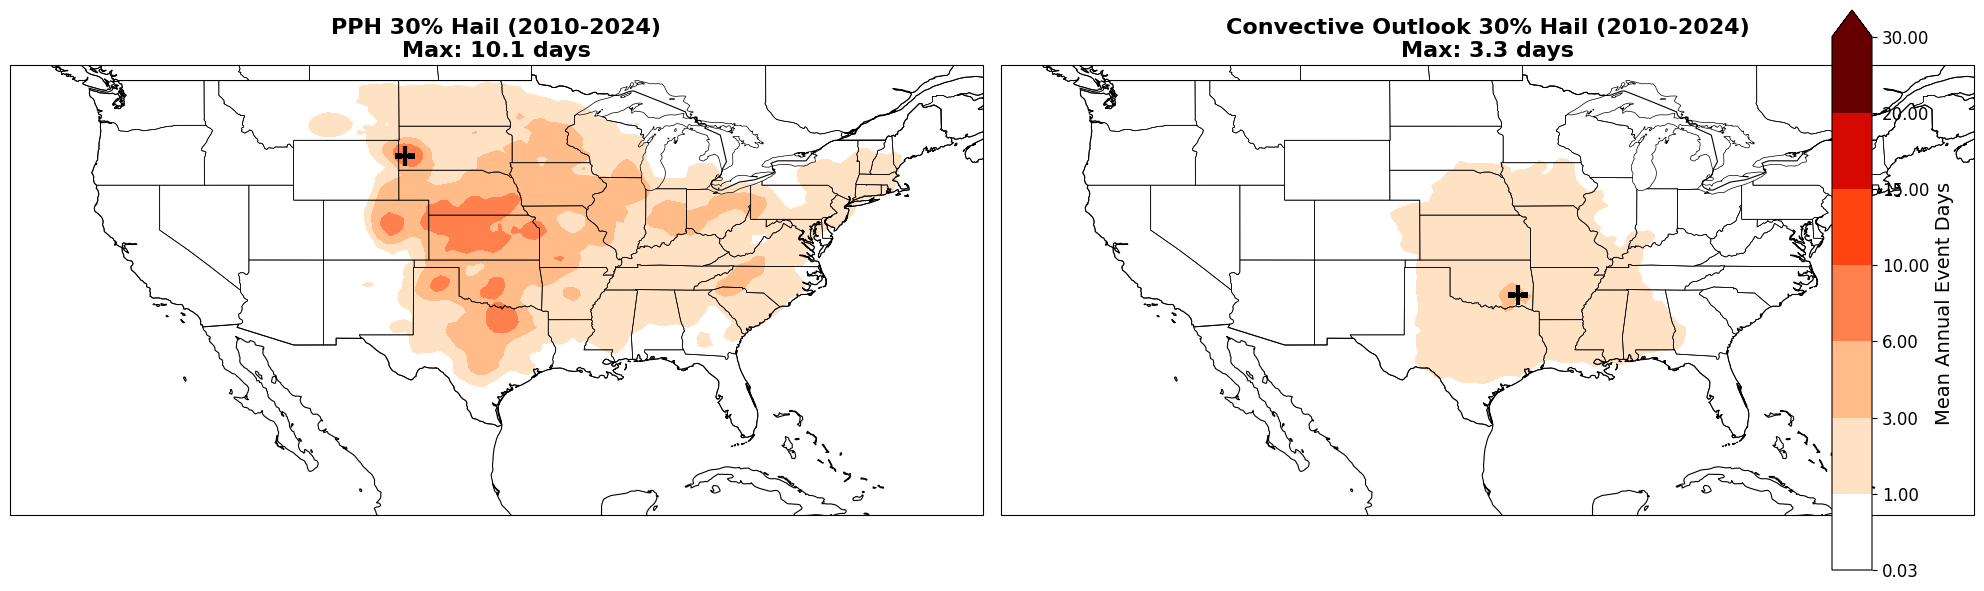

✅ HAIL 30% plot completed and saved to organized directory


In [174]:
# Task 1B: Plot HAIL 30% Results
print("📊 PLOTTING HAIL 30% COMPARISON")
print("="*50)

plot_mean_annual_event_days(hail_30_pph_mean, hail_30_outlook_mean, 'hail', 30)

print(f"✅ HAIL 30% plot completed and saved to organized directory")


In [178]:
# Task 1C: Process SIGHAIL 10% Data
print("🔄 PROCESSING SIGHAIL 10%")
print("="*50)

# Process outlooks
sighail_10_outlook_annual = []
for year in range(START_YEAR, END_YEAR + 1):
    grid = process_outlooks_for_year('sighail', 10, year)
    sighail_10_outlook_annual.append(grid)
sighail_10_outlook_mean = np.mean(sighail_10_outlook_annual, axis=0)

# Process PPH
sighail_10_pph_annual = []
for year in range(START_YEAR, END_YEAR + 1):
    grid = process_pph_for_year('sighail', 10, year)
    sighail_10_pph_annual.append(grid)
sighail_10_pph_mean = np.mean(sighail_10_pph_annual, axis=0)

print(f"✅ SIGHAIL 10% Complete")
print(f"   📊 PPH Max: {np.max(sighail_10_pph_mean):.1f} days")
print(f"   📊 Outlook Max: {np.max(sighail_10_outlook_mean):.1f} days")


🔄 PROCESSING SIGHAIL 10%
   📦 Loading cached outlook data for 2010
   📦 Loading cached outlook data for 2011
   📦 Loading cached outlook data for 2012
   📦 Loading cached outlook data for 2013
   📦 Loading cached outlook data for 2014
   📦 Loading cached outlook data for 2015
   📦 Loading cached outlook data for 2016
   📦 Loading cached outlook data for 2017
   📦 Loading cached outlook data for 2018
   📦 Loading cached outlook data for 2019
   📦 Loading cached outlook data for 2020
   📦 Loading cached outlook data for 2021
   📦 Loading cached outlook data for 2022
   📦 Loading cached outlook data for 2023
   📦 Loading cached outlook data for 2024
   🔄 Processing sighail 10% PPH for 2010
      ✓ Processed 365 days with PPH data
   🔄 Processing sighail 10% PPH for 2011
      ✓ Processed 365 days with PPH data
   🔄 Processing sighail 10% PPH for 2012
      ✓ Processed 366 days with PPH data
   🔄 Processing sighail 10% PPH for 2013
      ✓ Processed 365 days with PPH data
   🔄 Processing s

📊 PLOTTING SIGHAIL 10% COMPARISON
💾 Saved plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/mean_annual_event_days/mean_annual_sighail_10pct_2010-2024.png


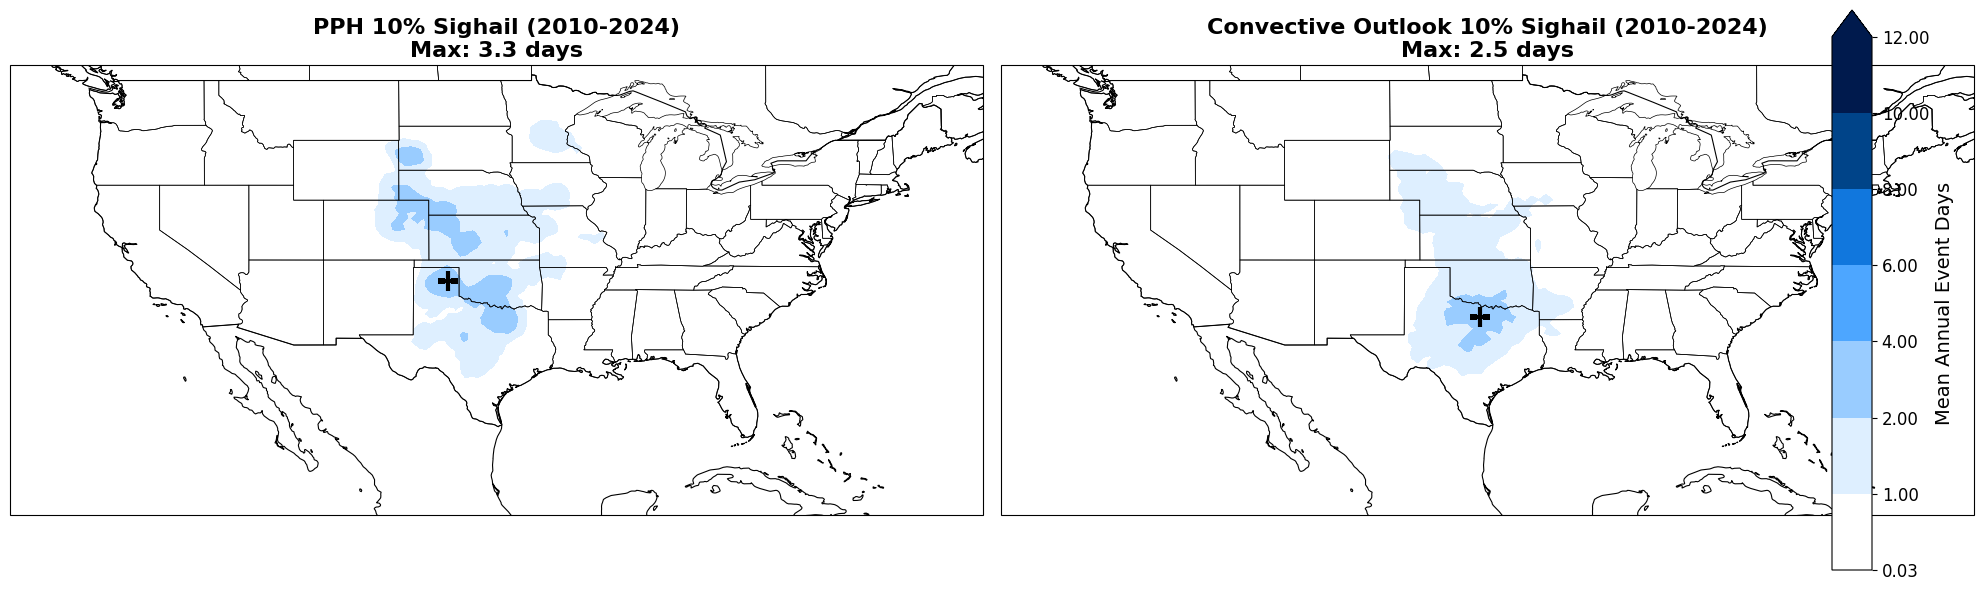

✅ SIGHAIL 10% plot completed and saved to organized directory


In [180]:
# Task 1C: Plot SIGHAIL 10% Results
print("📊 PLOTTING SIGHAIL 10% COMPARISON")
print("="*50)

plot_mean_annual_event_days(sighail_10_pph_mean, sighail_10_outlook_mean, 'sighail', 10)

print(f"✅ SIGHAIL 10% plot completed and saved to organized directory")


In [189]:
# Area Coverage Time Series Functions
def calculate_area_coverage(grid_data):
    """Calculate area coverage in km² from grid data."""
    return np.sum(grid_data > 0) * CELL_AREA_KM2

def process_monthly_coverage(hazard_type, threshold, data_type='pph'):
    """Process monthly area coverage for a hazard type and threshold."""
    cache_file = f"cache/monthly_coverage_{data_type}_{hazard_type}_{threshold}_{START_YEAR}_{END_YEAR}.pkl"
    
    if os.path.exists(cache_file):
        print(f"   📦 Loading cached monthly {data_type} coverage data")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    print(f"   🔄 Processing monthly {data_type} {hazard_type} {threshold}% coverage")
    
    monthly_coverage = []
    date_labels = []
    
    for year in range(START_YEAR, END_YEAR + 1):
        for month in range(1, 13):
            month_coverage = 0
            days_in_month = 0
            
            # Get days in month
            if month == 12:
                next_month = datetime(year + 1, 1, 1)
            else:
                next_month = datetime(year, month + 1, 1)
            current_date = datetime(year, month, 1)
            
            while current_date < next_month:
                if data_type == 'pph':
                    data = load_pph_data(current_date, hazard_type)
                    if data is not None:
                        grid = (data >= threshold/100.0).astype(float)
                        month_coverage += calculate_area_coverage(grid)
                        days_in_month += 1
                else:  # outlook
                    outlook_path = get_outlook_path(current_date, hazard_type)
                    if outlook_path and outlook_path.exists():
                        try:
                            grid = shapefile_to_nam212_grid(outlook_path, threshold, grid_shape, grid_lons, grid_lats)
                            month_coverage += calculate_area_coverage(grid)
                            days_in_month += 1
                        except:
                            pass
                
                current_date += timedelta(days=1)
            
            # Average daily coverage for the month
            avg_coverage = month_coverage / days_in_month if days_in_month > 0 else 0
            monthly_coverage.append(avg_coverage)
            date_labels.append(f"{year}-{month:02d}")
    
    result = {'coverage': monthly_coverage, 'dates': date_labels}
    
    with open(cache_file, 'wb') as f:
        pickle.dump(result, f)
    
    return result

def process_yearly_coverage(hazard_type, threshold, data_type='pph'):
    """Process yearly area coverage for a hazard type and threshold."""
    cache_file = f"cache/yearly_coverage_{data_type}_{hazard_type}_{threshold}_{START_YEAR}_{END_YEAR}.pkl"
    
    if os.path.exists(cache_file):
        print(f"   📦 Loading cached yearly {data_type} coverage data")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    print(f"   🔄 Processing yearly {data_type} {hazard_type} {threshold}% coverage")
    
    yearly_coverage = []
    
    for year in range(START_YEAR, END_YEAR + 1):
        year_coverage = 0
        days_in_year = 0
        
        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31)
        current_date = start_date
        
        while current_date <= end_date:
            if data_type == 'pph':
                data = load_pph_data(current_date, hazard_type)
                if data is not None:
                    grid = (data >= threshold/100.0).astype(float)
                    year_coverage += calculate_area_coverage(grid)
                    days_in_year += 1
            else:  # outlook
                outlook_path = get_outlook_path(current_date, hazard_type)
                if outlook_path and outlook_path.exists():
                    try:
                        grid = shapefile_to_nam212_grid(outlook_path, threshold, grid_shape, grid_lons, grid_lats)
                        year_coverage += calculate_area_coverage(grid)
                        days_in_year += 1
                    except:
                        pass
            
            current_date += timedelta(days=1)
        
        # Average daily coverage for the year
        avg_coverage = year_coverage / days_in_year if days_in_year > 0 else 0
        yearly_coverage.append(avg_coverage)
    
    result = {'coverage': yearly_coverage, 'years': list(range(START_YEAR, END_YEAR + 1))}
    
    with open(cache_file, 'wb') as f:
        pickle.dump(result, f)
    
    return result

print("✅ Area coverage time series functions defined")


✅ Area coverage time series functions defined


In [193]:
# Time Series Plotting Functions
def plot_area_coverage_timeseries(time_type='monthly'):
    """Create comprehensive time series plots for area coverage."""
    
    # Define hazard configurations for 3 types
    hazard_configs = [
        {'hazard': 'hail', 'threshold': 15, 'pph_color': '#2E8B57', 'outlook_color': '#90EE90'},
        {'hazard': 'hail', 'threshold': 30, 'pph_color': '#B22222', 'outlook_color': '#FFA07A'},
        {'hazard': 'sighail', 'threshold': 10, 'pph_color': '#4169E1', 'outlook_color': '#87CEEB'}
    ]
    
    fig, ax = plt.subplots(figsize=(16, 10))
    max_coverage = 0
    
    for config in hazard_configs:
        hazard = config['hazard']
        threshold = config['threshold']
        pph_color = config['pph_color']
        outlook_color = config['outlook_color']
        
        # Process data
        if time_type == 'monthly':
            pph_data = process_monthly_coverage(hazard, threshold, 'pph')
            outlook_data = process_monthly_coverage(hazard, threshold, 'outlook')
            x_data = [datetime.strptime(date, '%Y-%m') for date in pph_data['dates']]
        else:  # yearly
            pph_data = process_yearly_coverage(hazard, threshold, 'pph')
            outlook_data = process_yearly_coverage(hazard, threshold, 'outlook')
            x_data = pph_data['years']
        
        # Plot PPH line (solid)
        pph_label = f"PPH {hazard.capitalize()} {threshold}%"
        ax.plot(x_data, pph_data['coverage'], color=pph_color, linestyle='-', 
               linewidth=2.5, marker='o', markersize=4, label=pph_label, alpha=0.8)
        
        # Plot Outlook line (dashed)
        outlook_label = f"Outlook {hazard.capitalize()} {threshold}%"
        ax.plot(x_data, outlook_data['coverage'], color=outlook_color, linestyle='--', 
               linewidth=2.5, marker='s', markersize=4, label=outlook_label, alpha=0.8)
        
        # Track max coverage
        max_coverage = max(max_coverage, max(pph_data['coverage']), max(outlook_data['coverage']))
    
    # Formatting
    ax.set_ylabel('Area Coverage (km²)', fontsize=14, weight='bold')
    ax.set_title(f'{time_type.capitalize()} Area Coverage: PPH vs Convective Outlooks ({START_YEAR}-{END_YEAR})', 
                fontsize=16, weight='bold', pad=20)
    
    if time_type == 'monthly':
        ax.set_xlabel('Month-Year', fontsize=14, weight='bold')
        # Format x-axis for monthly data
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator([1, 7]))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    else:
        ax.set_xlabel('Year', fontsize=14, weight='bold')
        ax.set_xticks(range(START_YEAR, END_YEAR + 1, 2))
    
    # Grid and legend
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, 
             ncol=2, fontsize=11, bbox_to_anchor=(0.02, 0.98))
    
    # Y-axis formatting
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    ax.set_ylim(0, max_coverage * 1.1)
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    
    plt.tight_layout()
    
    # Save plot
    filename = f"area_coverage_{time_type}_{START_YEAR}-{END_YEAR}.png"
    save_path = TIME_SERIES_PATH / filename
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"💾 Saved {time_type} plot to {save_path}")
    
    plt.show()
    return fig

print("✅ Time series plotting functions defined")


✅ Time series plotting functions defined


In [191]:
# Enhanced Individual Comparison Plotting Function
def plot_individual_comparison_enhanced(hazard_type, threshold, time_type='monthly'):
    """Create enhanced individual comparison plots for specific hazard type and threshold."""
    
    # Process data based on time type
    if time_type == 'monthly':
        pph_data = process_monthly_coverage(hazard_type, threshold, 'pph')
        outlook_data = process_monthly_coverage(hazard_type, threshold, 'outlook')
        x_data = [datetime.strptime(date, '%Y-%m') for date in pph_data['dates']]
        x_label = 'Month-Year'
        title_period = f'{time_type.capitalize()} Comparison'
    else:  # yearly
        pph_data = process_yearly_coverage(hazard_type, threshold, 'pph')
        outlook_data = process_yearly_coverage(hazard_type, threshold, 'outlook')
        x_data = pph_data['years']
        x_label = 'Year'
        title_period = f'{time_type.capitalize()} Comparison'
    
    # Create enhanced plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Color scheme based on hazard type
    if hazard_type == 'hail' and threshold == 15:
        pph_color = '#2E8B57'  # Sea Green
        outlook_color = '#90EE90'  # Light Green
    elif hazard_type == 'hail' and threshold == 30:
        pph_color = '#B22222'  # Fire Brick
        outlook_color = '#FFA07A'  # Light Salmon
    else:  # sighail
        pph_color = '#4169E1'  # Royal Blue
        outlook_color = '#87CEEB'  # Sky Blue
    
    # Plot PPH data (solid line with circles)
    ax.plot(x_data, pph_data['coverage'], color=pph_color, linestyle='-', 
           linewidth=3, marker='o', markersize=6, label=f'PPH {hazard_type.capitalize()} {threshold}%', 
           alpha=0.9, markerfacecolor='white', markeredgewidth=2)
    
    # Plot Outlook data (dashed line with squares)
    ax.plot(x_data, outlook_data['coverage'], color=outlook_color, linestyle='--', 
           linewidth=3, marker='s', markersize=6, label=f'Convective Outlook {hazard_type.capitalize()} {threshold}%', 
           alpha=0.9, markerfacecolor='white', markeredgewidth=2)
    
    # Enhanced styling
    ax.set_ylabel('Area Coverage (km²)', fontsize=14, weight='bold')
    ax.set_xlabel(x_label, fontsize=14, weight='bold')
    ax.set_title(f'{title_period}: {hazard_type.capitalize()} {threshold}% Coverage\n'
                f'PPH vs Convective Outlooks ({START_YEAR}-{END_YEAR})', 
                fontsize=16, weight='bold', pad=20)
    
    # Format axes
    if time_type == 'monthly':
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator([1, 7]))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    else:
        ax.set_xticks(range(START_YEAR, END_YEAR + 1, 2))
    
    # Enhanced grid and legend
    ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, 
             fontsize=12, framealpha=0.9)
    
    # Y-axis formatting
    max_coverage = max(max(pph_data['coverage']), max(outlook_data['coverage']))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    ax.set_ylim(0, max_coverage * 1.1)
    
    # Professional styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    # Add summary statistics box
    pph_mean = np.mean(pph_data['coverage'])
    outlook_mean = np.mean(outlook_data['coverage'])
    
    stats_text = f'Mean Coverage:\nPPH: {pph_mean/1000:.1f}K km²\nOutlook: {outlook_mean/1000:.1f}K km²'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    # Save plot to organized directory
    filename = f"individual_{time_type}_{hazard_type}_{threshold}pct_{START_YEAR}-{END_YEAR}.png"
    save_path = TIME_SERIES_PATH / filename
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"💾 Saved {hazard_type} {threshold}% {time_type} plot to {save_path}")
    
    plt.show()
    return fig

print("✅ Enhanced individual comparison plotting function defined")


✅ Enhanced individual comparison plotting function defined


📊 GENERATING ENHANCED INDIVIDUAL MONTHLY COMPARISON PLOTS

🔄 Processing HAIL 15% monthly comparison...
   📦 Loading cached monthly pph coverage data
   📦 Loading cached monthly outlook coverage data
💾 Saved hail 15% monthly plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/time_series/individual_monthly_hail_15pct_2010-2024.png


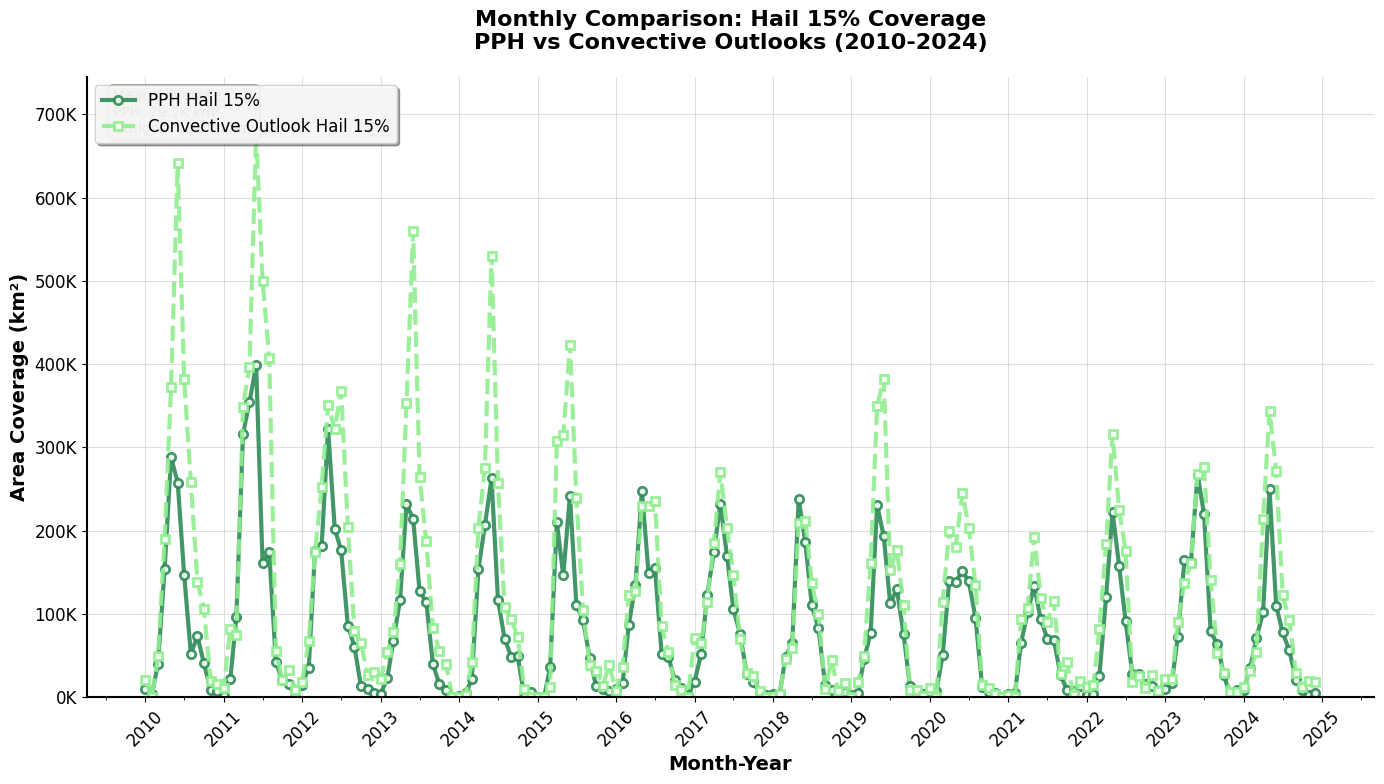


🔄 Processing HAIL 30% monthly comparison...
   📦 Loading cached monthly pph coverage data
   📦 Loading cached monthly outlook coverage data
💾 Saved hail 30% monthly plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/time_series/individual_monthly_hail_30pct_2010-2024.png


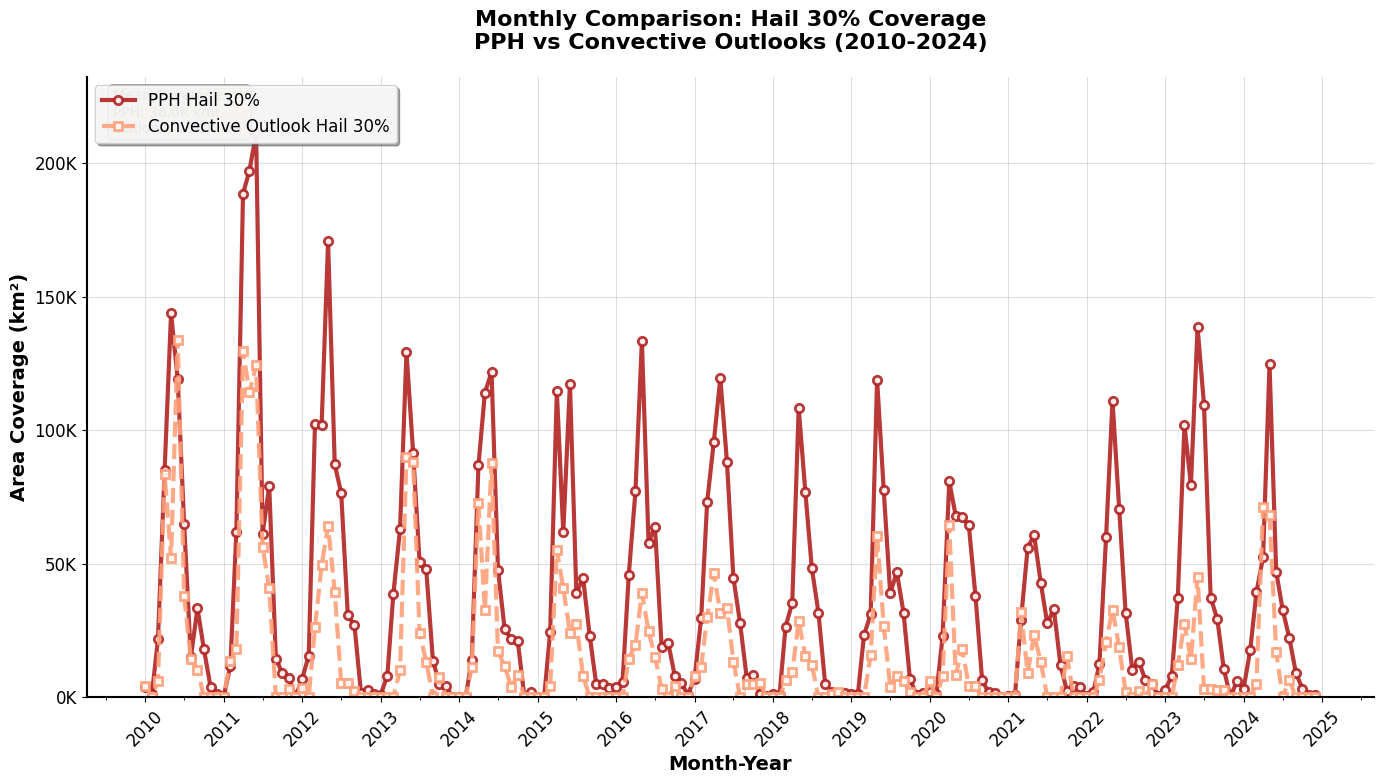


🔄 Processing SIGHAIL 10% monthly comparison...
   📦 Loading cached monthly pph coverage data
   📦 Loading cached monthly outlook coverage data
💾 Saved sighail 10% monthly plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/time_series/individual_monthly_sighail_10pct_2010-2024.png


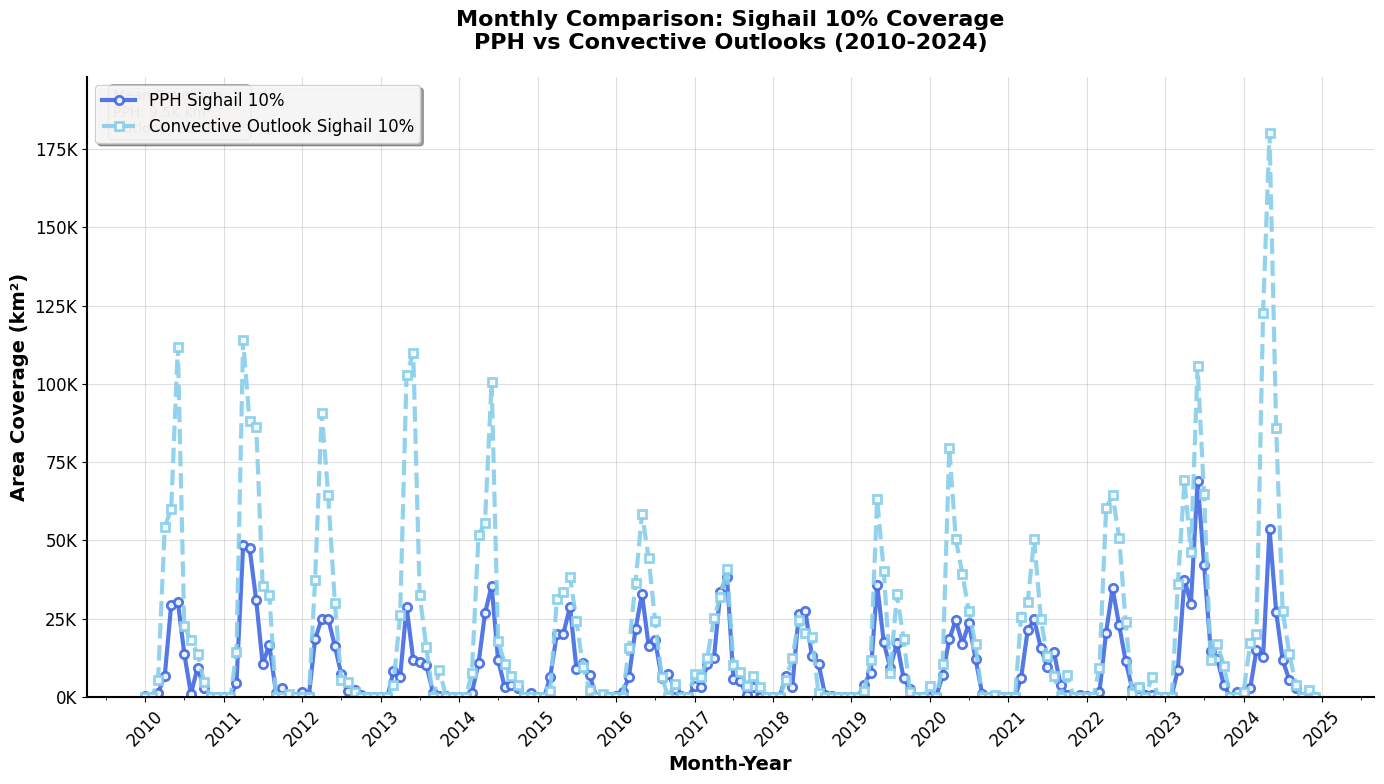


✅ All enhanced individual monthly comparison plots completed and saved to organized directory


In [192]:
# Task 2C
print("📊 GENERATING ENHANCED INDIVIDUAL MONTHLY COMPARISON PLOTS")
print("="*65)

enhanced_hazard_configs = [
    ('hail', 15),
    ('hail', 30), 
    ('sighail', 10),
]

for hazard_type, threshold in enhanced_hazard_configs:
    print(f"\n🔄 Processing {hazard_type.upper()} {threshold}% monthly comparison...")
    plot_individual_comparison_enhanced(hazard_type, threshold, 'monthly')

print("\n✅ All enhanced individual monthly comparison plots completed and saved to organized directory")


📈 GENERATING ENHANCED INDIVIDUAL YEARLY COMPARISON PLOTS

🔄 Processing HAIL 15% yearly comparison...
   📦 Loading cached yearly pph coverage data
   📦 Loading cached yearly outlook coverage data
💾 Saved hail 15% yearly plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/time_series/individual_yearly_hail_15pct_2010-2024.png


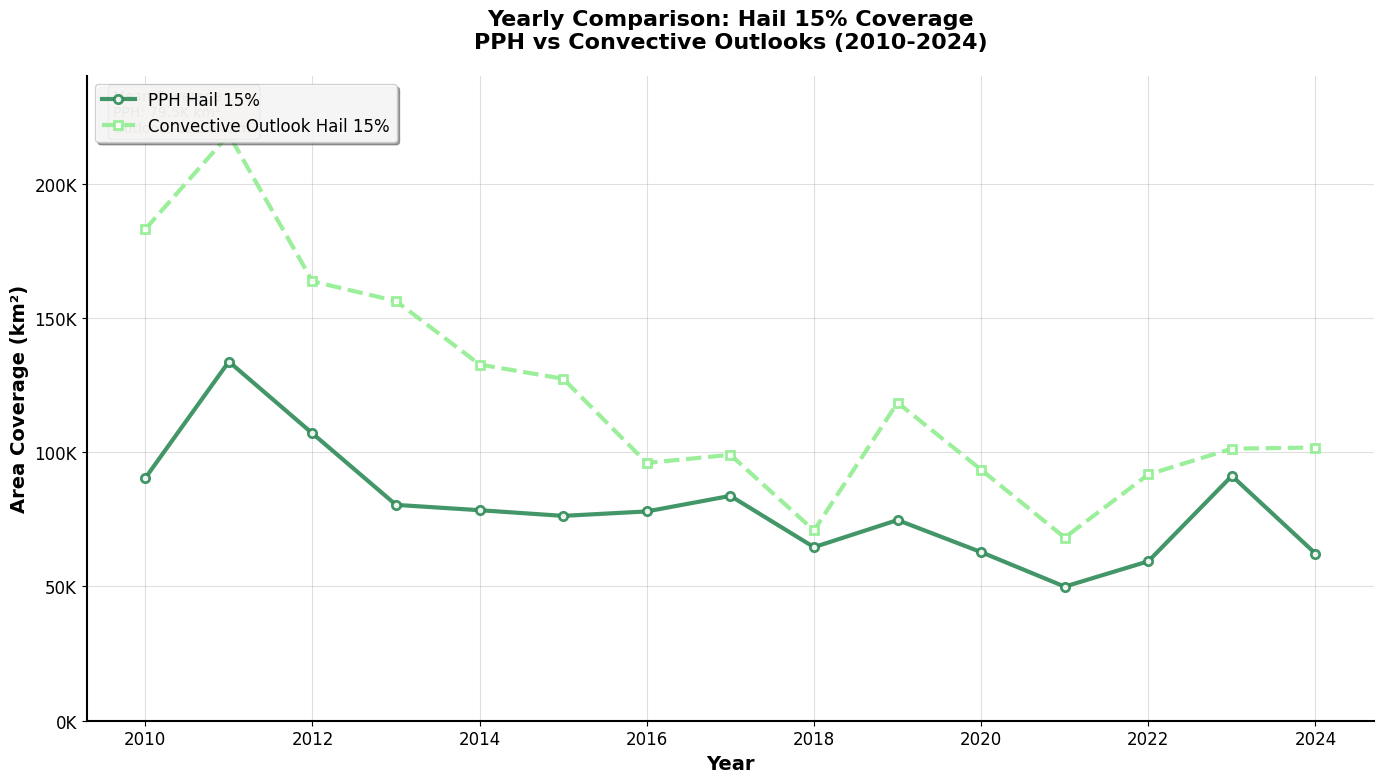


🔄 Processing HAIL 30% yearly comparison...
   📦 Loading cached yearly pph coverage data
   📦 Loading cached yearly outlook coverage data
💾 Saved hail 30% yearly plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/time_series/individual_yearly_hail_30pct_2010-2024.png


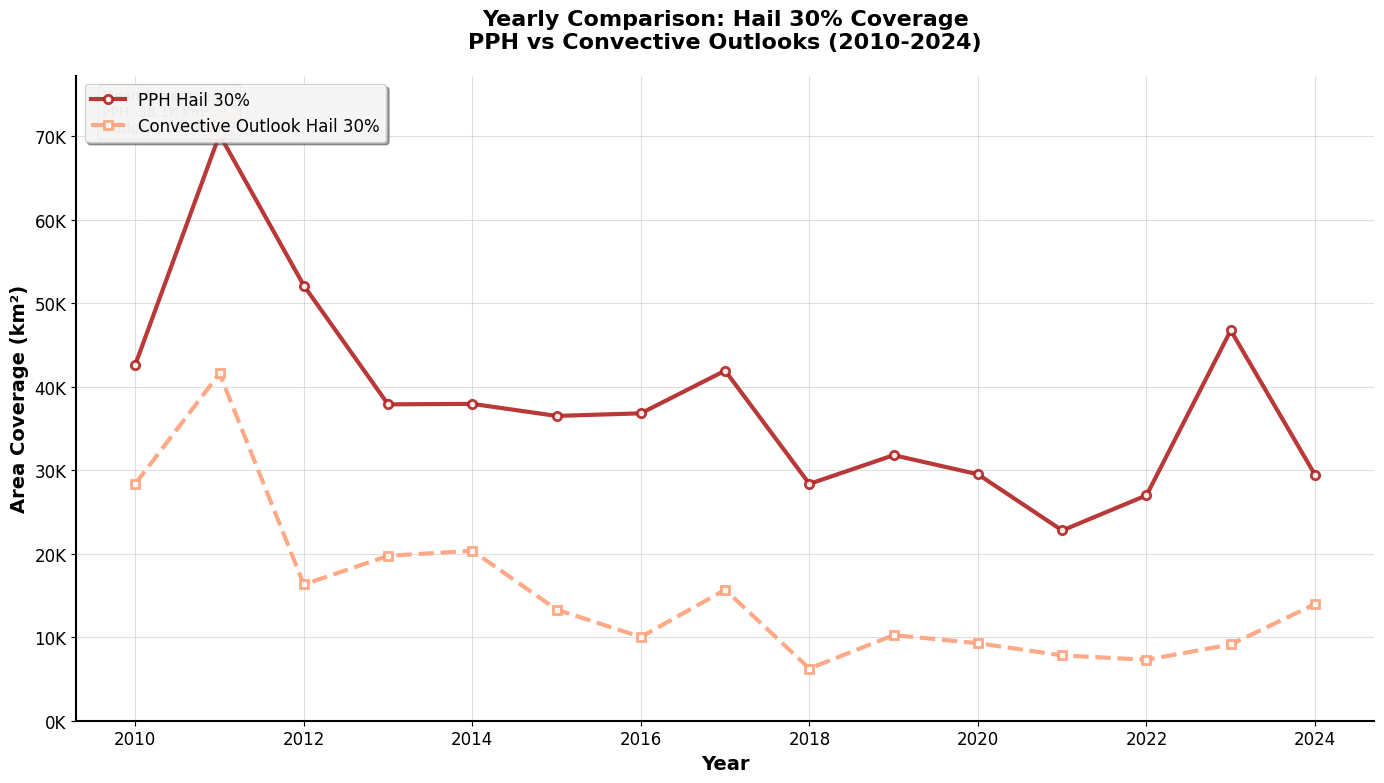


🔄 Processing SIGHAIL 10% yearly comparison...
   📦 Loading cached yearly pph coverage data
   📦 Loading cached yearly outlook coverage data
💾 Saved sighail 10% yearly plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/time_series/individual_yearly_sighail_10pct_2010-2024.png


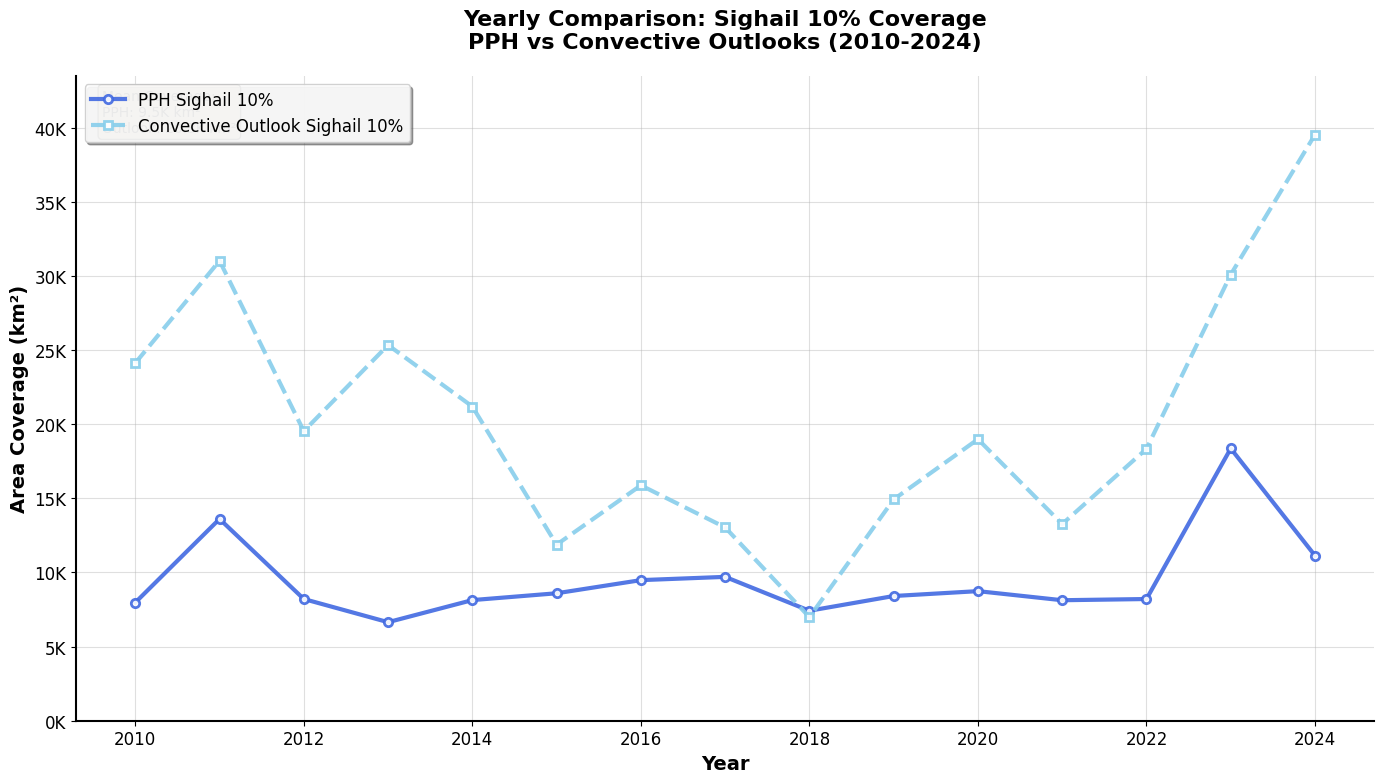


✅ All enhanced individual yearly comparison plots completed and saved to organized directory


In [194]:
# Task 2D Enhanced: Individual Yearly Comparison Plots 
print("📈 GENERATING ENHANCED INDIVIDUAL YEARLY COMPARISON PLOTS")
print("="*65)

# Generate enhanced individual yearly plots for each hazard type/threshold
for hazard_type, threshold in enhanced_hazard_configs:
    print(f"\n🔄 Processing {hazard_type.upper()} {threshold}% yearly comparison...")
    plot_individual_comparison_enhanced(hazard_type, threshold, 'yearly')

print("\n✅ All enhanced individual yearly comparison plots completed and saved to organized directory")


In [195]:
# Daily Overlap Analysis Functions
def calculate_jaccard_index(grid1, grid2):
    """
    Calculate Jaccard Index (Intersection over Union) between two binary grids.
    
    Jaccard = |A ∩ B| / |A ∪ B| = Overlap / (Area1 + Area2 - Overlap)
    """
    # Convert to binary masks
    mask1 = grid1 > 0
    mask2 = grid2 > 0
    
    # Calculate areas in terms of grid cells
    area1 = np.sum(mask1)
    area2 = np.sum(mask2)
    overlap = np.sum(mask1 & mask2)
    
    # Jaccard Index formula
    union = area1 + area2 - overlap
    
    if union == 0:
        return 0.0  # Both grids are empty
    
    return overlap / union

def process_daily_overlap_timeseries(pph_hazard, pph_threshold, outlook_hazard, outlook_threshold):
    """
    Calculate daily overlap timeseries between PPH and convective outlook.
    
    Returns a list of tuples: (date, jaccard_index)
    """
    cache_file = f"cache/overlap_timeseries_{pph_hazard}_{outlook_hazard}_{pph_threshold}_{outlook_threshold}_{START_YEAR}_{END_YEAR}.pkl"
    
    if os.path.exists(cache_file):
        print(f"   📦 Loading cached overlap data for {pph_hazard} {pph_threshold}% vs {outlook_hazard} {outlook_threshold}%")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    print(f"   🔄 Processing daily overlap: {pph_hazard} {pph_threshold}% PPH vs {outlook_hazard} {outlook_threshold}% Outlook")
    
    daily_overlaps = []
    
    # Process each day from 2010-2024
    start_date = datetime(START_YEAR, 1, 1)
    end_date = datetime(END_YEAR, 12, 31)
    current_date = start_date
    
    processed_days = 0
    while current_date <= end_date:
        # Load PPH data
        pph_data = load_pph_data(current_date, pph_hazard)
        pph_grid = None
        if pph_data is not None:
            pph_grid = (pph_data >= pph_threshold/100.0).astype(float)
        
        # Load Outlook data
        outlook_path = get_outlook_path(current_date, outlook_hazard)
        outlook_grid = None
        if outlook_path and outlook_path.exists():
            try:
                outlook_grid = shapefile_to_nam212_grid(outlook_path, outlook_threshold, grid_shape, grid_lons, grid_lats)
            except:
                outlook_grid = None
        
        # Calculate overlap if both datasets are available
        jaccard_index = np.nan
        if pph_grid is not None and outlook_grid is not None:
            jaccard_index = calculate_jaccard_index(pph_grid, outlook_grid)
            processed_days += 1
        
        daily_overlaps.append((current_date, jaccard_index))
        current_date += timedelta(days=1)
    
    print(f"      ✓ Processed {processed_days} days with both PPH and Outlook data")
    
    # Cache results
    with open(cache_file, 'wb') as f:
        pickle.dump(daily_overlaps, f)
    
    return daily_overlaps

def plot_overlap_timeseries(pph_hazard, pph_threshold, outlook_hazard, outlook_threshold):
    """
    Create time series plot of daily overlap fractions.
    """
    # Get overlap data
    daily_data = process_daily_overlap_timeseries(pph_hazard, pph_threshold, outlook_hazard, outlook_threshold)
    
    # Extract dates and values, filtering out NaN values
    dates = []
    values = []
    for date, jaccard in daily_data:
        if not np.isnan(jaccard):
            dates.append(date)
            values.append(jaccard * 100)  # Convert to percentage
    
    if len(dates) == 0:
        print(f"   ⚠️ No valid data for {pph_hazard} {pph_threshold}% vs {outlook_hazard} {outlook_threshold}%")
        return None
    
    # Create plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Color scheme based on hazard type
    if pph_hazard == 'hail':
        color = '#2E8B57' if pph_threshold == 15 else '#B22222'
    else:  # sighail
        color = '#4169E1'
    
    # Plot time series
    ax.plot(dates, values, color=color, linewidth=1.5, alpha=0.7, marker='.', markersize=2)
    
    # Add rolling mean for trend visualization
    if len(values) > 30:
        values_series = pd.Series(values, index=dates)
        rolling_mean = values_series.rolling(window=30, center=True).mean()
        ax.plot(dates, rolling_mean, color=color, linewidth=3, alpha=0.9, 
               label=f'30-day rolling mean')
    
    # Formatting
    ax.set_ylabel('Overlap Fraction (%)', fontsize=14, weight='bold')
    ax.set_xlabel('Date', fontsize=14, weight='bold')
    
    title = f'Daily Overlap: {pph_hazard.capitalize()} {pph_threshold}% PPH vs {outlook_hazard.capitalize()} {outlook_threshold}% Outlook'
    ax.set_title(f'{title} ({START_YEAR}-{END_YEAR})', fontsize=16, weight='bold', pad=20)
    
    # X-axis formatting
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator([1, 7]))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Grid and styling
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_ylim(0, 100)
    
    # Add statistics text
    mean_overlap = np.mean(values)
    std_overlap = np.std(values)
    max_overlap = np.max(values)
    
    stats_text = f'Mean: {mean_overlap:.1f}%\nStd: {std_overlap:.1f}%\nMax: {max_overlap:.1f}%\nDays: {len(values):,}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
           verticalalignment='top', fontsize=11)
    
    if len(values) > 30:
        ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    
    plt.tight_layout()
    
    # Save plot
    filename = f"daily_overlap_{pph_hazard}_{pph_threshold}pct_vs_{outlook_hazard}_{outlook_threshold}pct_{START_YEAR}-{END_YEAR}.png"
    
    # Create overlap directory if it doesn't exist
    overlap_path = FIGURES_PATH / "daily_overlap"
    os.makedirs(overlap_path, exist_ok=True)
    
    save_path = overlap_path / filename
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"💾 Saved overlap plot to {save_path}")
    
    plt.show()
    return fig

print("✅ Daily overlap analysis functions defined")


✅ Daily overlap analysis functions defined


🔄 GENERATING HAIL 15% PPH DAILY OVERLAP PLOTS

📊 Processing Hail 15% PPH vs 5% Outlook...
   📦 Loading cached overlap data for hail 15% vs hail 5%
💾 Saved overlap plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/daily_overlap/daily_overlap_hail_15pct_vs_hail_5pct_2010-2024.png


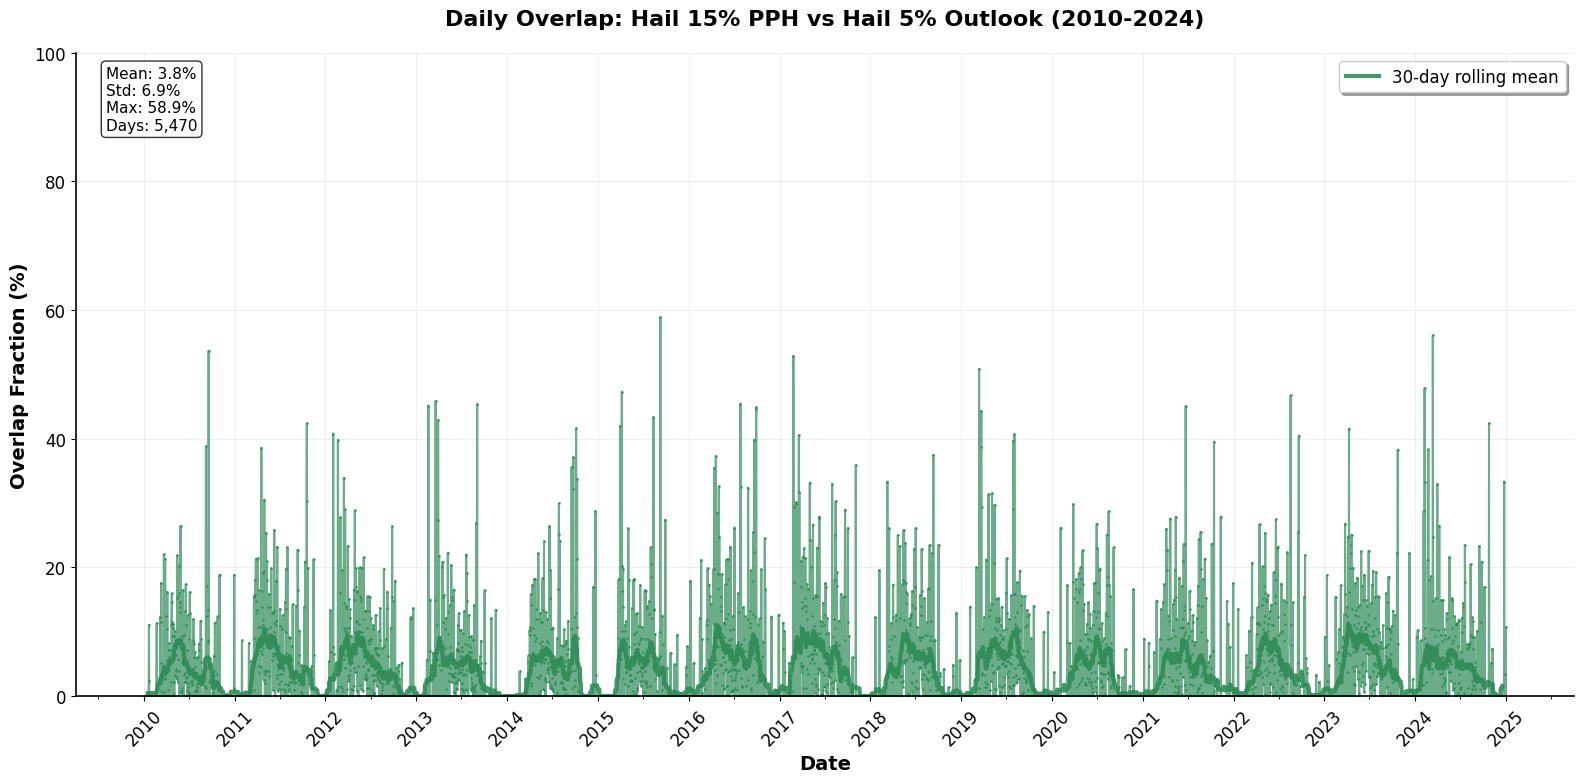


📊 Processing Hail 15% PPH vs 10% Outlook...
   📦 Loading cached overlap data for hail 15% vs hail 10%
💾 Saved overlap plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/daily_overlap/daily_overlap_hail_15pct_vs_hail_10pct_2010-2024.png


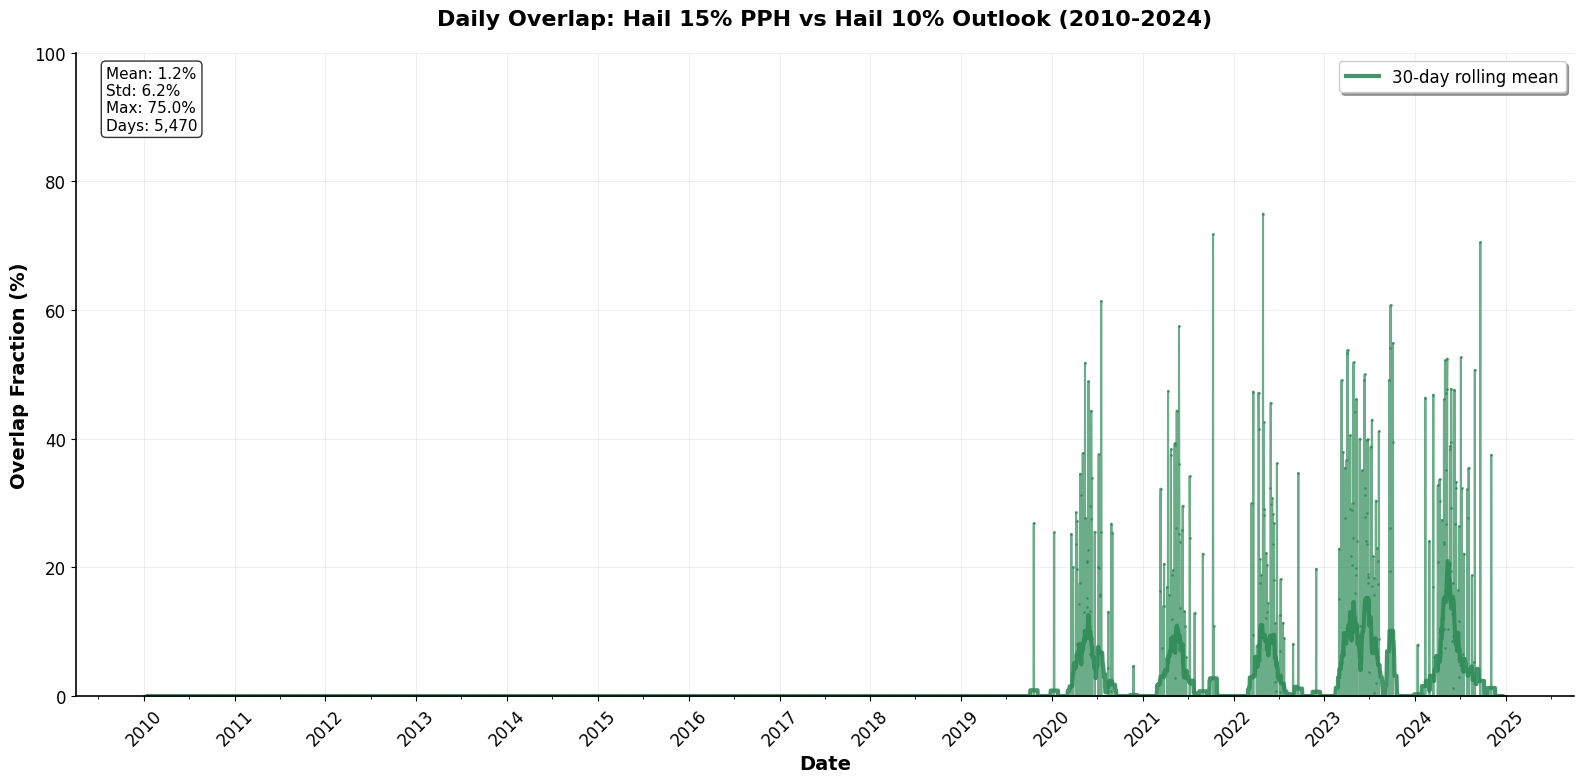


📊 Processing Hail 15% PPH vs 15% Outlook...
   📦 Loading cached overlap data for hail 15% vs hail 15%
💾 Saved overlap plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/daily_overlap/daily_overlap_hail_15pct_vs_hail_15pct_2010-2024.png


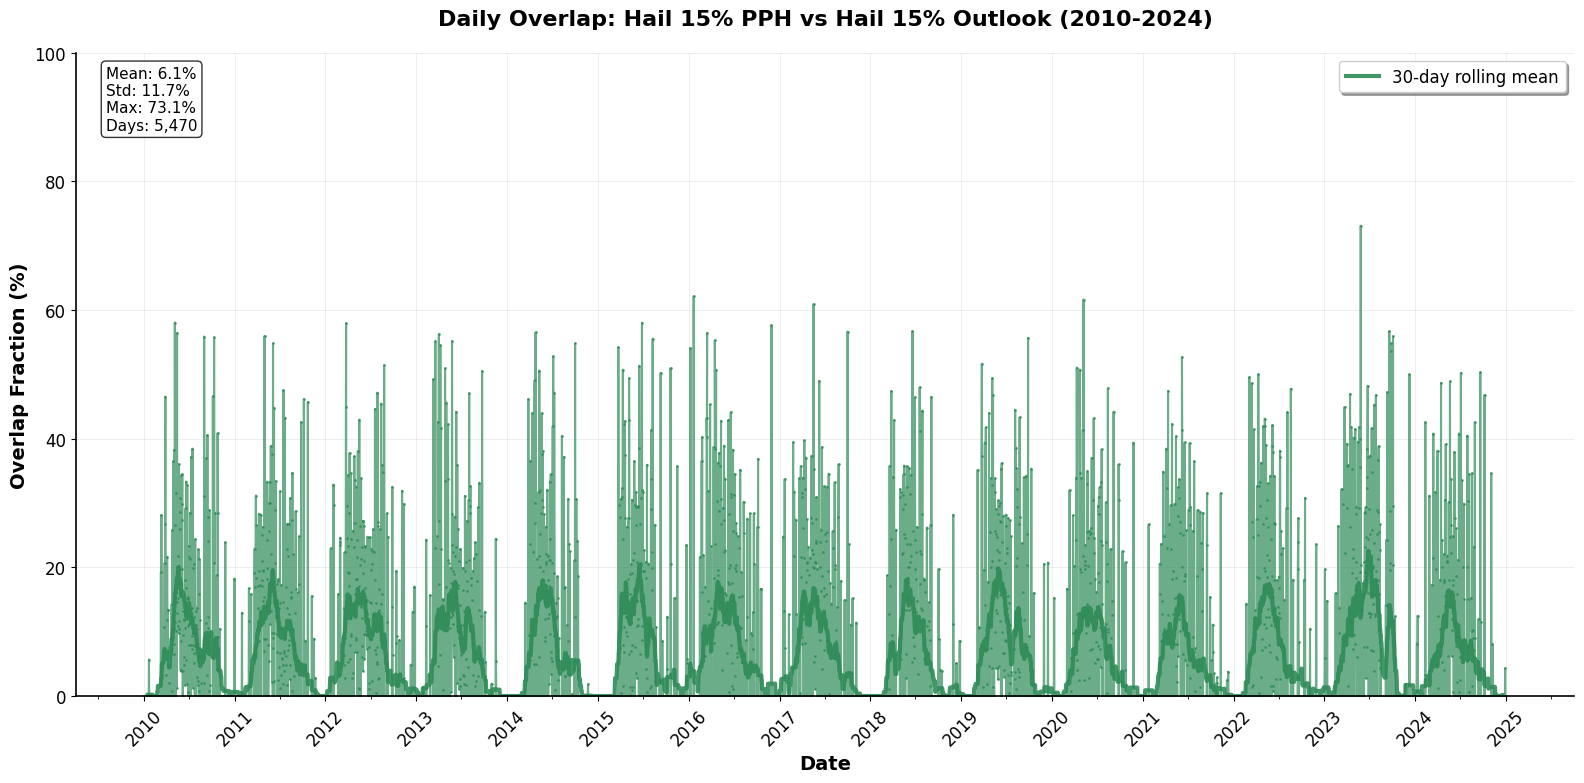


📊 Processing Hail 15% PPH vs 30% Outlook...
   📦 Loading cached overlap data for hail 15% vs hail 30%
💾 Saved overlap plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/daily_overlap/daily_overlap_hail_15pct_vs_hail_30pct_2010-2024.png


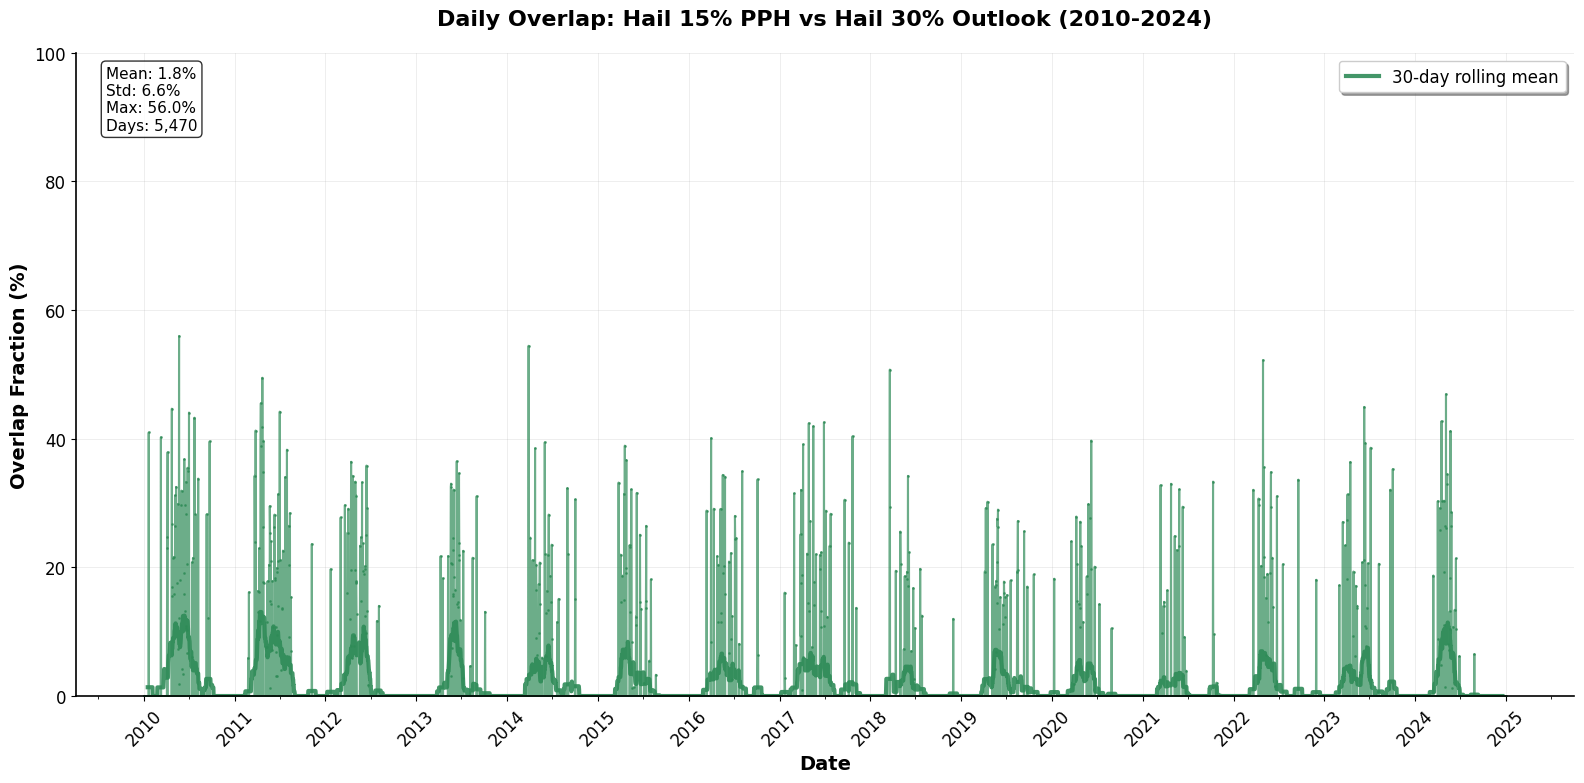


📊 Processing Hail 15% PPH vs 45% Outlook...
   📦 Loading cached overlap data for hail 15% vs hail 45%
💾 Saved overlap plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/daily_overlap/daily_overlap_hail_15pct_vs_hail_45pct_2010-2024.png


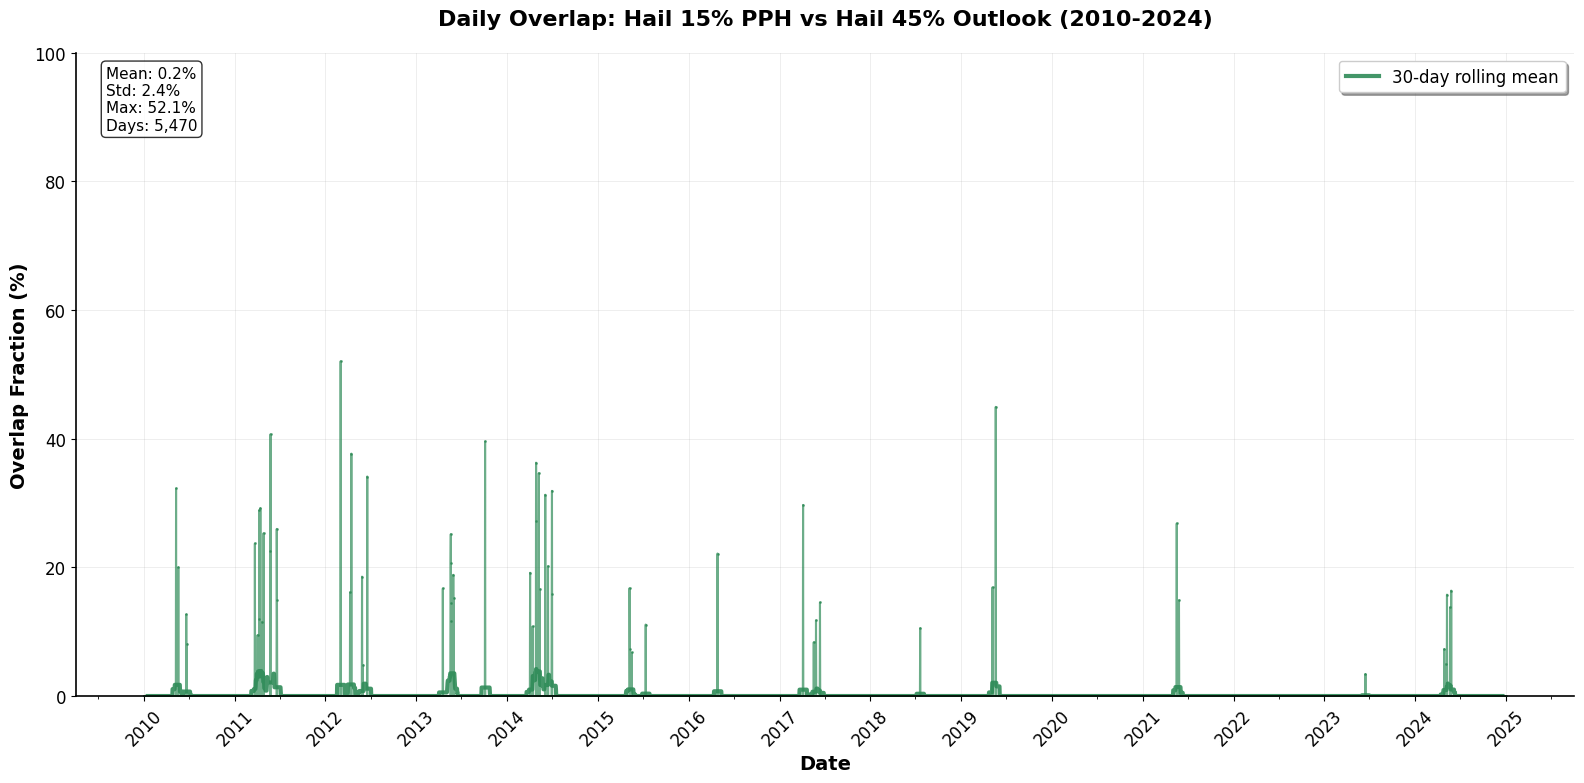


✅ Hail 15% PPH overlap plots completed


In [197]:
# Task 3A: Hail 15% PPH Daily Overlap Analysis
print("🔄 GENERATING HAIL 15% PPH DAILY OVERLAP PLOTS")
print("="*55)

# Hail 15% PPH vs different convective outlook thresholds
#hail_15_outlook_thresholds = [5, 10, 15, 30, 45, 60]
#10% only has 2020 onwards
hail_15_outlook_thresholds = [5, 10, 15, 30, 45]

for outlook_threshold in hail_15_outlook_thresholds:
    print(f"\n📊 Processing Hail 15% PPH vs {outlook_threshold}% Outlook...")
    plot_overlap_timeseries('hail', 15, 'hail', outlook_threshold)

print("\n✅ Hail 15% PPH overlap plots completed")


🔄 GENERATING HAIL 30% PPH DAILY OVERLAP PLOTS

📊 Processing Hail 30% PPH vs 15% Outlook...
   📦 Loading cached overlap data for hail 30% vs hail 15%
💾 Saved overlap plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/daily_overlap/daily_overlap_hail_30pct_vs_hail_15pct_2010-2024.png


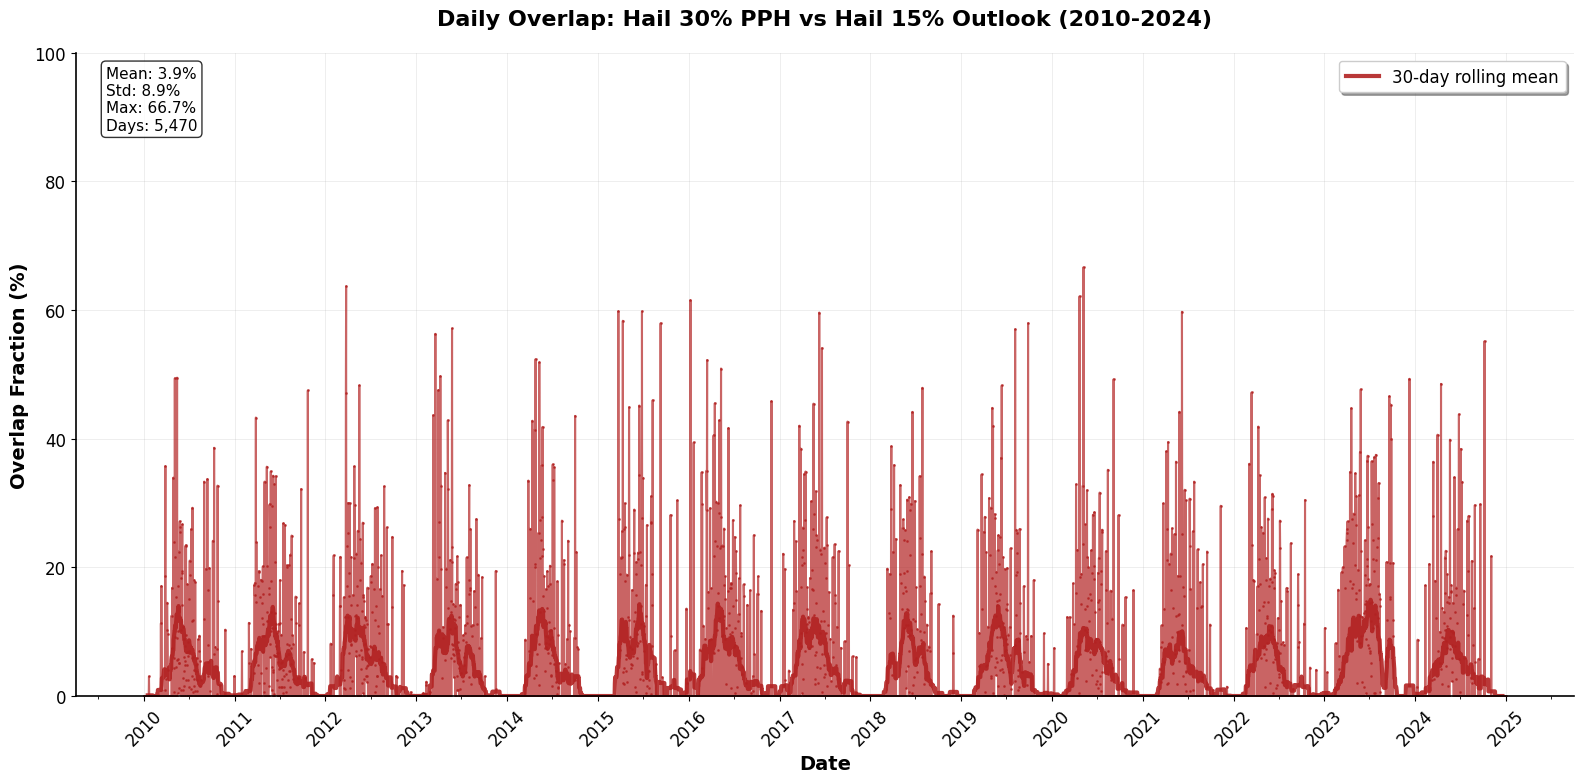


📊 Processing Hail 30% PPH vs 30% Outlook...
   📦 Loading cached overlap data for hail 30% vs hail 30%
💾 Saved overlap plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/daily_overlap/daily_overlap_hail_30pct_vs_hail_30pct_2010-2024.png


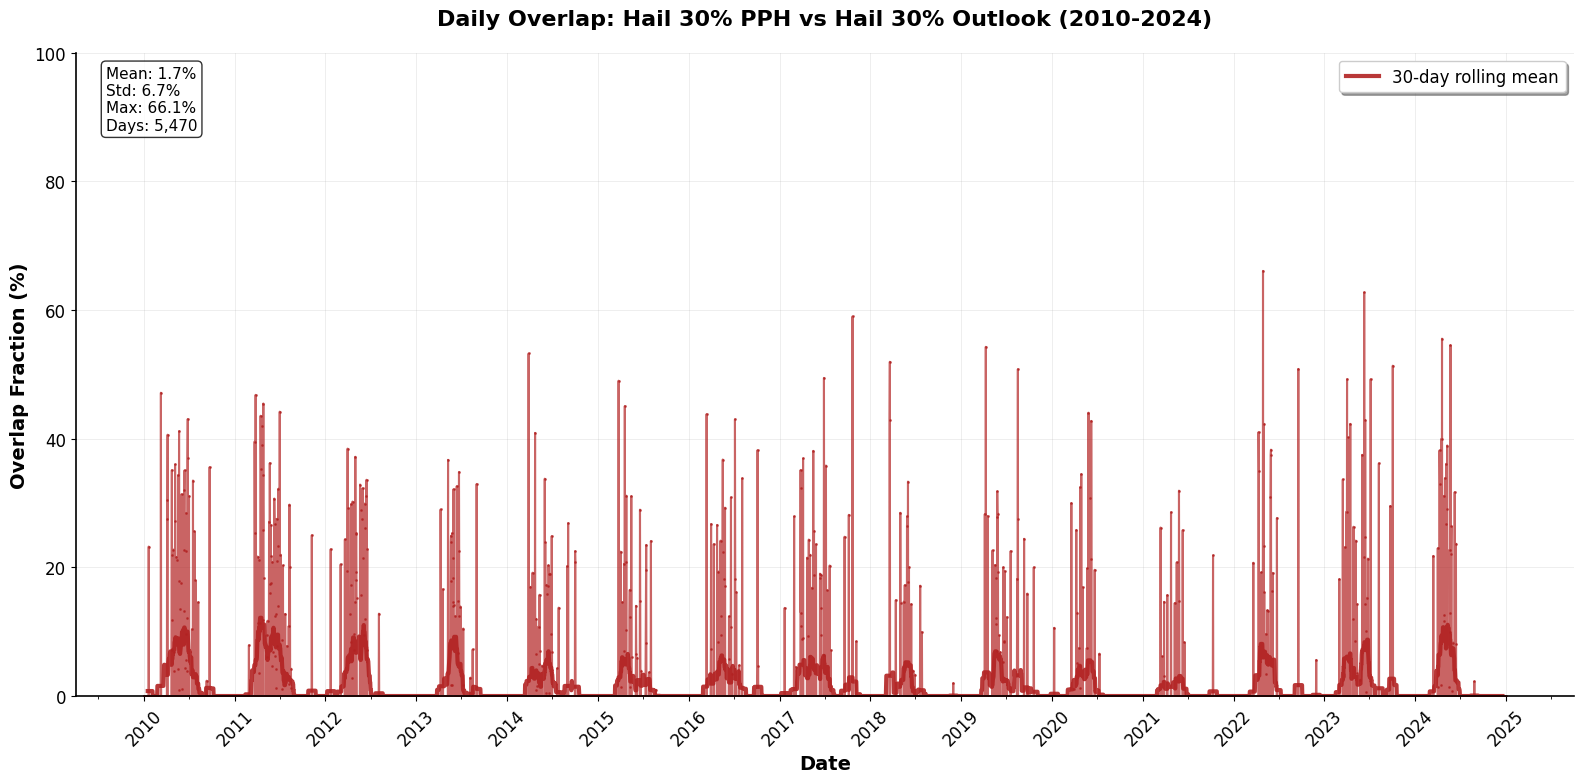


✅ Hail 30% PPH overlap plots completed


In [200]:
# Task 3B: Hail 30% PPH Daily Overlap Analysis
print("🔄 GENERATING HAIL 30% PPH DAILY OVERLAP PLOTS")
print("="*55)

# Hail 30% PPH vs different convective outlook thresholds
hail_30_outlook_thresholds = [15, 30]

for outlook_threshold in hail_30_outlook_thresholds:
    print(f"\n📊 Processing Hail 30% PPH vs {outlook_threshold}% Outlook...")
    plot_overlap_timeseries('hail', 30, 'hail', outlook_threshold)

print("\n✅ Hail 30% PPH overlap plots completed")


🔄 GENERATING SIGHAIL 10% PPH DAILY OVERLAP PLOTS

📊 Processing SigHail 10% PPH vs 10% Outlook...
   📦 Loading cached overlap data for sighail 10% vs sighail 10%
💾 Saved overlap plot to /Users/jimnguyen/IRMII/SCS_API/analysis_outputs/figures/daily_overlap/daily_overlap_sighail_10pct_vs_sighail_10pct_2010-2024.png


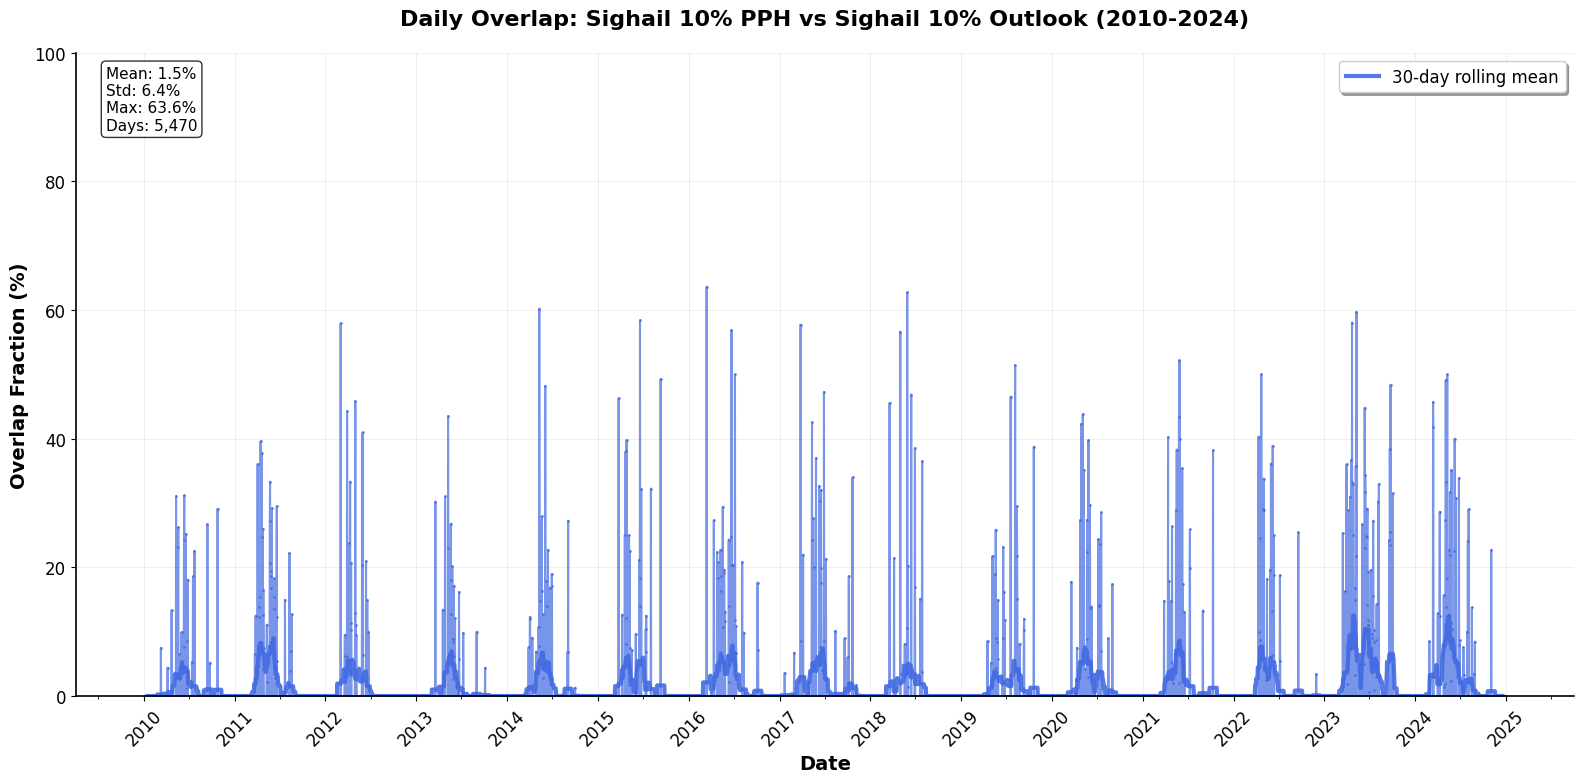


✅ SigHail 10% PPH overlap plots completed


In [201]:
# Task 3C: SigHail 10% PPH Daily Overlap Analysis
print("🔄 GENERATING SIGHAIL 10% PPH DAILY OVERLAP PLOTS")
print("="*55)

# SigHail 10% PPH vs different convective outlook thresholds
sighail_10_outlook_thresholds = [10]

for outlook_threshold in sighail_10_outlook_thresholds:
    print(f"\n📊 Processing SigHail 10% PPH vs {outlook_threshold}% Outlook...")
    plot_overlap_timeseries('sighail', 10, 'sighail', outlook_threshold)

print("\n✅ SigHail 10% PPH overlap plots completed")
    